In [97]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

# NAME = 'ladle_furnace_inference'

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Modelling steel level depending on Zpoca mean**

In [99]:
# Choose scenario
#Scenario = "BigGapHighRes"
#Scenario = "BigGap"
#Scenario = "SmallGap"
Scenario = "NotCentred"

In [100]:
# Choose geometric limits of POCA
Limits = "Fx_20_80_Fy_20_80_Fz_50_150"

In [101]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Limits + "/" + Scenario + "_TrueSteelLevels.csv")
Poca_z_means = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Limits + "/" + Scenario + "_PocaZmeans.csv")


### Set minimum limit for steel level range

In [102]:
MinLevel = 0.4

In [103]:
TrueSteelLevels[TrueSteelLevels>=MinLevel], Poca_z_means[TrueSteelLevels>=MinLevel]

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6,
        0.7, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4,
        0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6, 0.7,
        0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8]),
 array([0.7850436 , 0.9519102 , 1.0281651 , 0.97254968, 1.00296032,
        0.88804835, 0.85341281, 0.95037574, 1.0032208 , 1.04307258,
        0.89423609, 0.92118168, 1.01724827, 1.00743651, 1.00937998,
        0.8863098 , 0.82076234, 1.04001236, 1.05300474, 1.02075589,
        0.94076258, 0.99460953, 0.88358754, 0.97800684, 1.06199217,
        0.79450732, 1.0457077 , 0.96261281, 0.95193595, 1.14056599,
        0.90863079, 0.94446939, 0.90593415, 0.9787032 , 1.0280565 ,
        0.89729798, 0.89017946, 0.93704575, 0.94575304, 1.06641901,
        0.97277445, 0.96513265, 0.94966513, 1.07143903, 1.05872858,
        1.07104802, 0.87236607, 0.98355961, 0.9868027 , 1.10535681]))

In [104]:
Train_target = TrueSteelLevels[TrueSteelLevels>=MinLevel]
Train_in = Poca_z_means[TrueSteelLevels>=MinLevel]

Residuals – sum of squared residuals of the least squares fit: 0.1595
        2
0.4478 x - 0.1687 x + 0.8999


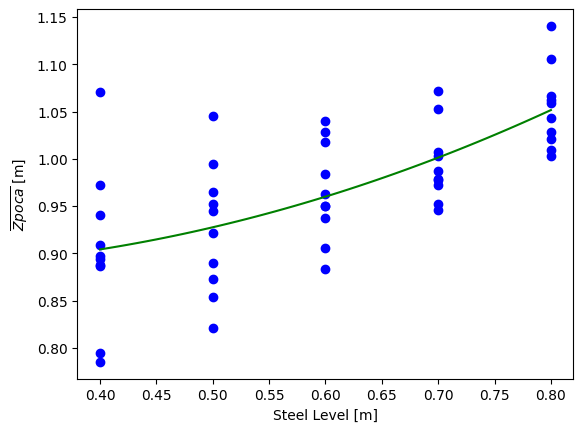

In [105]:
# Quadratic fit

plt.plot(Train_target, Train_in, "bo")

model = np.poly1d(np.polyfit(Train_target, Train_in, 2))

print("Residuals – sum of squared residuals of the least squares fit: " + str(round(np.polyfit(Train_target, Train_in, 2, full=True)[1][0], 4)))

polyline = np.linspace(min(Train_target), max(Train_target), 50)
plt.plot(polyline, model(polyline), "g")

plt.xlabel('Steel Level [m]')
plt.ylabel('$\overline{Zpoca}$ [m]')

print(model)

# x=0.7
# model[2]*x*x + model[1]*x + model[0]

In [106]:
#define function to calculate r-squared
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)   # get coeefficients as numpy.ndarray
    p = np.poly1d(coeffs)
    
    #https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    # calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    
    ssreg = np.sum((yhat-ybar)**2)
    ssres = np.sum((y - yhat)**2)
    sstot = np.sum((y - ybar)**2)
    
    #results['r_squared'] = ssreg / sstot

    #return results
    
    # return ssreg / sstot # R squared for linear regression, as explaned variance
    return 1 - (ssres / sstot) # R squared for linear regression, as explaned variance ()

#find r-squared of polynomial model with degree = 2
# polyfit(Train_target, Train_in, 2)
# round(polyfit(Train_target, Train_in, 2), 3)

0.4
0.07800938305341974
0.5
0.06489053011969666
0.6000000000000001
0.04902776712353187
0.7000000000000001
0.038516144144951005
0.8
0.041066485562513945


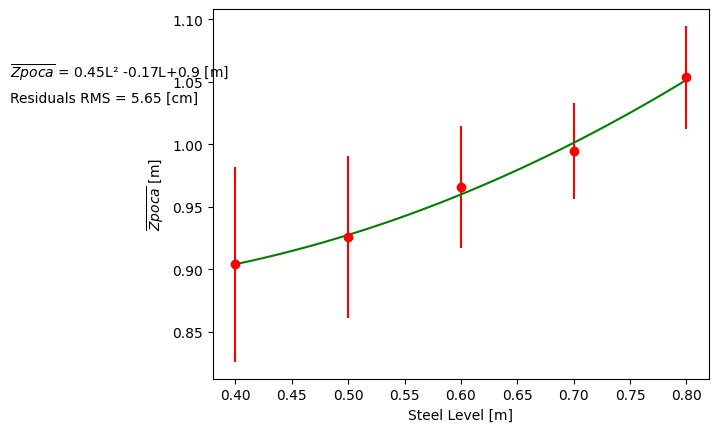

In [107]:
g_m = np.empty((np.unique(Train_target).shape[0], ))
g_m[:] = np.nan
g_sd = np.empty((np.unique(Train_target).shape[0], ))
g_sd[:] = np.nan

for i in range(0, np.unique(Train_target).shape[0]):
    print((np.unique(Train_target)[i]))
    g_m[i] = np.mean(Train_in[Train_target==(np.unique(Train_target)[i])])
    g_sd[i] = np.std(Train_in[Train_target==(np.unique(Train_target)[i])])
    #print(pred_1[TrueSteel==(np.unique(TrueSteel)[i])])
    
    print(g_sd[i])
    
g_m, g_sd



#np.savetxt(folder + "_Mean_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_m], delimiter=",")
#np.savetxt(folder + "_SD_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_sd], delimiter=",")


sigma = 1
# sigma = 3

#plt.plot(np.unique(TrueSteel), g_m, "bo")
#plt.errorbar(np.unique(TrueSteel), g_m, yerr=g_sd*2, fmt="o") # 2 sigma
plt.errorbar(np.unique(Train_target), g_m, yerr=g_sd*sigma, fmt="ro") # 3 sigma

plt.xlabel('Steel Level [m]')
plt.ylabel('$\overline{Zpoca}$ [m]')

#e = pred_1-TrueSteel
#m = np.mean(e)
#sd = np.std(e)
#rms = np.sqrt(np.mean(np.square(e)))

#plt.text(0.40, 0.69, ("mean = " + str(round(m*100, 2)) + " cm"))
#plt.text(0.40, 0.67, ("sd = " + str(round(sd*100, 2)) + " cm"))
#plt.text(0.40, 0.65, ("RMSE = " + str(round(rms*100, 2)) + " cm"))

MIN = min(Train_target)
MAX = max(Train_target)
#plt.plot( [MIN,MAX],[MIN,MAX] )

#plt.text(0.40, max(g_m), model)
plt.text(0.20, max(g_m), (  "$\overline{Zpoca}$ = "  +  str(round(model[2], 2))  + 'L² '  +  str(round(model[1], 2))  + 'L+'  +  str(round(model[0], 2)) + " [m]" ) )
#plt.text(0.40, max(g_m) - 0.005, (  str(round(model[2], 2))  + 'L² '  +  str(round(model[1], 2))  + 'L+'  +  str(round(model[0], 2))  ) )

# plt.text(0.40, max(g_m) - 0.01, (  "R² = " + str(round(polyfit(Train_target, Train_in, 2), 3))  ))

#plt.text(0.2, max(g_m) - 0.02, "Sum of squared residuals = " + str(round(np.polyfit(Train_target, Train_in, 2, full=True)[1][0], 4)))
plt.text(0.2, max(g_m) - 0.02, "Residuals RMS = " + str(round(np.sqrt(np.polyfit(Train_target, Train_in, 2, full=True)[1][0]/len(Train_in))*100, 2)) + " [cm]")


polyline = np.linspace(min(Train_target), max(Train_target), 50)
plt.plot(polyline, model(polyline), "g")

# plt.savefig(folder + 'PocaMeanZ_sigma_' + str(sigma) + '.png')

## **Testing built inference models**

In [108]:
model

poly1d([ 0.44778313, -0.16870192,  0.89991831])

In [109]:
Poca_z_means

array([0.99617893, 0.98778534, 0.98095781, 0.7850436 , 0.9519102 ,
       1.0281651 , 0.97254968, 1.00296032, 0.89401835, 0.98737079,
       0.92223346, 0.88804835, 0.85341281, 0.95037574, 1.0032208 ,
       1.04307258, 0.99966538, 0.94098186, 0.92796081, 0.89423609,
       0.92118168, 1.01724827, 1.00743651, 1.00937998, 0.96565729,
       1.03365862, 0.9842732 , 0.8863098 , 0.82076234, 1.04001236,
       1.05300474, 1.02075589, 0.85816038, 0.97575867, 0.85817242,
       0.94076258, 0.99460953, 0.88358754, 0.97800684, 1.06199217,
       0.91452646, 1.01369035, 0.86801535, 0.79450732, 1.0457077 ,
       0.96261281, 0.95193595, 1.14056599, 0.9169004 , 0.82258725,
       0.92544603, 0.90863079, 0.94446939, 0.90593415, 0.9787032 ,
       1.0280565 , 0.88379073, 0.93045634, 0.75011915, 0.89729798,
       0.89017946, 0.93704575, 0.94575304, 1.06641901, 1.00325823,
       1.03129888, 0.92167753, 0.97277445, 0.96513265, 0.94966513,
       1.07143903, 1.05872858, 1.05192292, 0.97610021, 0.81161

        2
0.4478 x - 0.1687 x + 0.8999
[ 0.17710611 -0.21185594  0.11943588  0.27083002  0.16041287  0.22078923
  0.0605166  -0.00735347 -0.07611781  0.11638941  0.22130636  0.30042687
  0.07188751  0.00493148  0.05842842  0.24915608  0.22967612  0.23353462
  0.18368838 -0.01080513 -0.14094105  0.2943512   0.32014588  0.25611999
 -0.06666823  0.09730374  0.20420983 -0.01620982  0.17124735  0.33798924
 -0.04712637 -0.19306694  0.30565856  0.14068451  0.119487    0.49398729
  0.06689474  0.03351027  0.10466313  0.02815646  0.17262988  0.27061441
 -0.28119386  0.01101046 -0.00312244  0.08992447  0.10721164  0.34677814
  0.05941287  0.16085912  0.14568734  0.11497859  0.35674474  0.3315098
 -0.15910641  0.35596845 -0.03848858  0.18227165  0.18871038  0.42408407]
[       nan 0.57772597 0.75572701 0.63299473 0.70373937 0.28312001
        nan 0.57330016 0.70430341 0.78434481 0.3393557  0.47642117
 0.73381849 0.7133481  0.71746569 0.25974775        nan 0.77858332
 0.80267195 0.74095249 0.54432

/tmp/ipykernel_6461/1700425143.py:11: RuntimeWarning: invalid value encountered in sqrt
  x = (-b+np.sqrt(b*b-4*a*c))/(2*a)


Text(0.4, 0.66, 'RMSE = 12.64 cm')

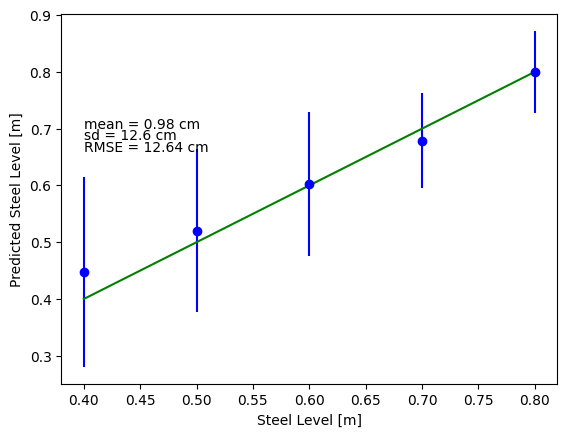

In [110]:
# TRAIN predictions (x)

print(model)
model[2], model[1], model[0]
print(b*b-4*a*c)

a =  model[2]
b =  model[1]
c =  model[0]-Train_in

x = (-b+np.sqrt(b*b-4*a*c))/(2*a)
len(x)
print(x)

# Set prediction lower limit to avoid nan 
x[np.isnan(x)]=MinLevel


# TRAIN ERROR

g_m = np.empty((np.unique(Train_target).shape[0], ))
g_m[:] = np.nan
g_sd = np.empty((np.unique(Train_target).shape[0], ))
g_sd[:] = np.nan

for i in range(0, np.unique(Train_target).shape[0]):
    print((np.unique(Train_target)[i]))
    g_m[i] = np.mean(x[Train_target==(np.unique(Train_target)[i])])
    g_sd[i] = np.std(x[Train_target==(np.unique(Train_target)[i])])
    #print(pred_1[TrueSteel==(np.unique(TrueSteel)[i])])
    
    print(g_m[i], g_sd[i])
    
g_m, g_sd

#np.savetxt(folder + "_Mean_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_m], delimiter=",")
#np.savetxt(folder + "_SD_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_sd], delimiter=",")


plt.errorbar(np.unique(Train_target), g_m, yerr=g_sd*sigma, fmt="bo") # 3 sigma


plt.xlabel('Steel Level [m]')
plt.ylabel('Predicted Steel Level [m]')
plt.plot( [MIN,MAX],[MIN,MAX] , "g")

e = x-Train_target
m = np.mean(e)
sd = np.std(e)
rms = np.sqrt(np.mean(np.square(e)))

plt.text(0.40, 0.70, ("mean = " + str(round(m*100, 2)) + " cm"))
plt.text(0.40, 0.68, ("sd = " + str(round(sd*100, 2)) + " cm"))
plt.text(0.40, 0.66, ("RMSE = " + str(round(rms*100, 2)) + " cm"))

# plt.savefig(folder + 'TrainPredictions_sigma_' + str(sigma) + '.png')

# folder